# Learning Model Segment 4

#### Looks at different types of supervised and deep learning models:
  * Logistic Regression    
  * Support Vector Machine
  * Deep Learning Model
  * Random Forest Model

In [1]:
# Choose type of model to run:
#     LR = logistic regression, NN = neural net, SV = support vector machine, RF = Random Forest Classifier

model_type = 'NN' 

In [2]:
def select_model(mtype):
    if mtype == 'LR':
        return 'U'
    elif mtype == 'NN':
        return 'S'
    elif mtype == 'SV':
        return 'S'
    elif mtype == 'RF':
        return 'S'
dataset = select_model(model_type)
print(model_type, dataset)

NN S


In [3]:
# Import dependancies
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
from sqlalchemy import create_engine
import psycopg2
import config as creds
import re
import csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Import data from Postgres db in AWS

In [4]:
# import all from config to get credentials and host and database names in postgress
from config import * 
database_string = f"postgresql://{PGUSER}:{PGPASSWORD}@{PGHOST}/{PGDATABASE}"

# create variable for the engine
engine = create_engine(database_string)

#def connect():
# Set up a connection to the postgres server.
conn_string = "host="+ creds.PGHOST +" port="+ "5432" +" dbname="+ creds.PGDATABASE +" user=" + creds.PGUSER \
                  +" password="+ creds.PGPASSWORD
conn = psycopg2.connect(conn_string)
print("Connected!")
# Create a cursor object
cursor = conn.cursor()
#return conn, cursor

Connected!


In [5]:
# read file from AWS joined_tables2 contains the combined IMDB/TMDB data
df = pd.read_sql_query('select * from join_final', conn)

In [6]:
# drop columns with high percentage of missing values, and not needed
df.drop(["budget", "collection", "metascore", "orig_lang_cd", "release_year",
              "original_language", "popularity", "revenue", "runtime", "usa_gross_income", 
              "website", "worlwide_gross_income"], axis=1, inplace=True)

# drop columns with too many unique values 
df.drop(["director_list", "country", "imdb_id", "language", "title"], axis=1, inplace=True)

# Choose dependent = predicted value:
# Options: avg_vote, reviews_from_critics, reviews_from_users, votes
# For this model pass, use avg_vote >= 7 as success
df["success"] = df["avg_vote"].map(lambda x: 1 if x>= 7.0 else 0)

# Drop unneeded dependent variables
df.drop(["avg_vote", "reviews_from_users", "reviews_from_critics", "votes"], axis=1, inplace=True)

# Drop any rows with missing values. Reassess whether the nulls can/should be recoded and kept.
df.dropna(axis=0, how="any", inplace=True)

# Categorical variables for encoding, if needed
cat_vars = [ 'g_action', 'g_adult',
       'g_adventure', 'g_animation', 'g_biography', 'g_comedy', 'g_crime',
       'g_documentary', 'g_drama', 'g_family', 'g_fantasy', 'g_history',
       'g_horror', 'g_music', 'g_musical', 'g_mystery', 'g_news',
       'g_reality_tv', 'g_romance', 'g_sci_fi', 'g_sport', 'g_thriller',
       'g_war', 'g_western']

print(df.columns)
print(f'\n number of movies: {len(df)}')
print(f'\n numner of success: {df["success"].sum()}')

Index(['year', 'duration', 'g_action', 'g_adult', 'g_adventure', 'g_animation',
       'g_biography', 'g_comedy', 'g_crime', 'g_documentary', 'g_drama',
       'g_family', 'g_fantasy', 'g_history', 'g_horror', 'g_music',
       'g_musical', 'g_mystery', 'g_news', 'g_reality_tv', 'g_romance',
       'g_sci_fi', 'g_sport', 'g_thriller', 'g_war', 'g_western', 'success'],
      dtype='object')

 number of movies: 70529

 numner of success: 12220


## Pre-process

In [7]:
if dataset == 'S':  # create encoded and scaled dataset
    # Encode categorical variables
    # Create a OneHotEncoder instance
    enc = OneHotEncoder(sparse=False)
    # Fit and transform the OneHotEncoder using the categorical variable list
    encode_df =pd.DataFrame(enc.fit_transform(df[cat_vars]))
    # Add the encoded variable names to the DataFrame
    encode_df.columns =enc.get_feature_names(cat_vars)
    # Merge one-hot encoded features and drop the originals
    df =df.merge(encode_df,left_index=True,right_index=True)
    df.drop(cat_vars,axis=1, inplace=True)

## Create Sample Datasets

In [8]:
# Split our preprocessed data into our features and target arrays
y =df["success"]
# y =df["success"].values
X =df.drop(["success"],1)
# X =df.drop(["success"],1).values

# Split the preprocessed data into a training and testing dataset
X_train,X_test,y_train,y_test =train_test_split(X,y,stratify=y,random_state=189)

# print sample sizes
print(f'\n size of training dataset: {len(y_train)}')
print(f'\n size of testing dataset: {len(y_test)}')


 size of training dataset: 52896

 size of testing dataset: 17633


## Scale data if needed

In [9]:
if dataset == 'S':  # create encoded and scaled dataset
    X_scaler = StandardScaler()
    # Fit the scaler
    X_scaler.fit(X_train)
    # Scale the data
    X_train =X_scaler.transform(X_train)
    X_test =X_scaler.transform(X_test)

## Define the learning model

## Random Forest Model

In [10]:
if model_type == "RF":
    rf_model = RandomForestClassifier(n_estimators=128, random_state=78) 
    rf_model = rf_model.fit(X_train, y_train)
    predictions = rf_model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    
    # Create a DataFrame from the confusion matrix.
    cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
    acc_score = accuracy_score(y_test, predictions)
    
    # Create a DataFrame from the confusion matrix.
    cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
    acc_score = accuracy_score(y_test, predictions)
    
    print(f"\n Random Forest Classifier accuracy: {acc_score:.3f}")
    print(f"\n Confusion Matrix: \n {cm_df}" )
    print(f"\n Classification Report: \n {classification_report(y_test, predictions)}")
    
    # Calculate feature importance in the Random Forest model.
    importances = rf_model.feature_importances_
    output=sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)
    output_df = pd.DataFrame(output, columns = ['importance','feature'])
    print(f"\n Feature Importances: \n {output_df}")

In [11]:
if model_type == "LR":
    log_classifier =LogisticRegression(solver="lbfgs",max_iter=200)
    log_classifier.fit(X_train,y_train)
    y_pred =log_classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    acc_score = accuracy_score(y_test, y_pred)
       
    # Get coefficients of the model
    coef = pd.Series(log_classifier.coef_.ravel())
    intercept = log_classifier.intercept_
    output=sorted(zip(coef, X.columns), reverse=True)
    output_df = pd.DataFrame(output, columns = ['Coefficient','Feature'])
    print(f" Logistic Regression model parameters: \n {output_df}")
    
    # Create a DataFrame from the confusion matrix.
    cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

    # Results
    print(f"\n Logistic Regression model accuracy: {acc_score:.3f}")
    print(f"\n Confusion Matrix: \n {cm_df}" )
    print(f"\n Classification Report: \n {classification_report(y_test, y_pred)}")
    

In [12]:
# Support Vector Machine - used model Linear SVC because svm =SVC(kernel='linear') kept hanging

if model_type == "SV":
    # Create the SVM model
    svm =LinearSVC()
    
    # Train the model
    svm.fit(X_train,y_train)
    
    # Evaluate the model
    y_pred =svm.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    acc_score = accuracy_score(y_test, y_pred)
       
    # Get coefficients of the model
    coef = pd.Series(svm.coef_.ravel())
    intercept = svm.intercept_
    output=sorted(zip(coef, X.columns), reverse=True)
    output_df = pd.DataFrame(output, columns = ['Coefficient','Feature'])
    print(f" SVM model parameters: \n {output_df}")
    
    # Create a DataFrame from the confusion matrix.
    cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

    print(f"\n Sypport Vector Machine model accuracy: {acc_score:.3f}")
    print(f"\n Confusion Matrix: \n {cm_df}" )
    print(f"\n Classification Report: \n {classification_report(y_test, y_pred)}")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5)                 255       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 18        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 4         
Total params: 277
Trainable params: 277
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1158/1158 [==============================] - 1s 738us/step - loss: 0.4456 - accuracy: 0.8029 - val_loss: 0.4035 - val_accuracy: 0.8268
Epoch 2/30
1158/1158 [==============================] - 1s 573us/step - loss: 0.4022 - accuracy: 0.8299 - val_loss: 0.4016 - val_accuracy: 0.8283
Epoch 3/30
1158/1158 [==============================] - 1s 609us/step - loss: 0.3995 - accuracy:

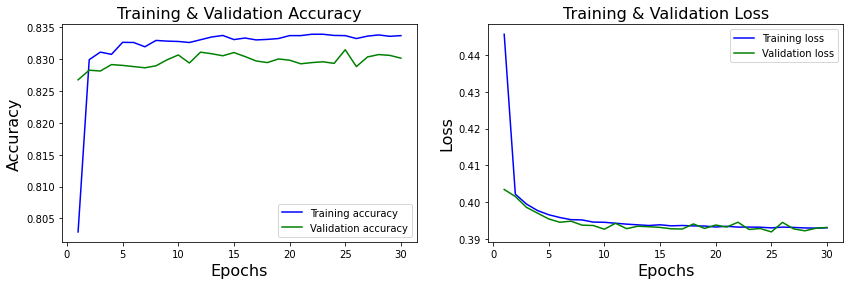

In [13]:
if model_type == "NN":
    # Create the Keras Sequential model
    # use validation_split argument to set the proportion of the dataset to reserve for validation
    number_input_features =len(X_train[0])
    hidden_nodes_layer1 = 5
    hidden_nodes_layer2 = 3
    nn =tf.keras.models.Sequential()
    # layers
    nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1,activation="tanh",input_dim=number_input_features))
    nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2,activation="tanh"))

    # Add the output layer that uses a probability activation function
    nn.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
    
    # Check the structure of the Sequential model
    nn.summary()

    # Compile the Sequential model together and customize metrics
    nn.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

    # Fit the model to the training data
    fit_model =nn.fit(X_train,y_train,validation_split=.3, epochs=30)

    # Evaluate the model using the test data
    y_pred = nn.predict_classes(X_test) 
    model_loss,model_accuracy = nn.evaluate(X_test,y_test,verbose=2)
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

    # Results of training:
    print("Training Results")
    print(f"\n Deep Learning model accuracy: {model_accuracy:.3f}   loss: {model_loss}")
    print(f"\n Confusion Matrix: \n {cm_df}" )
    print(f"\n Classification Report: \n {classification_report(y_test, y_pred)}")
    
    # Results based on validation Sample
    # Create learning curve for both train and validation datasets to evaluate under- and over-fitting
    print("Validation Results")
    history_dict=fit_model.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']

    epochs = range(1, len(loss_values) + 1)
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    #
    # Plot the model accuracy vs Epochs
    #
    ax[0].plot(epochs, accuracy, 'b', label='Training accuracy')
    ax[0].plot(epochs, val_accuracy, 'g', label='Validation accuracy')
    ax[0].set_title('Training & Validation Accuracy', fontsize=16)
    ax[0].set_xlabel('Epochs', fontsize=16)
    ax[0].set_ylabel('Accuracy', fontsize=16)
    ax[0].legend()
    #
    # Plot the loss vs Epochs
    #
    ax[1].plot(epochs, loss_values, 'b', label='Training loss')
    ax[1].plot(epochs, val_loss_values, 'g', label='Validation loss')
    ax[1].set_title('Training & Validation Loss', fontsize=16)
    ax[1].set_xlabel('Epochs', fontsize=16)
    ax[1].set_ylabel('Loss', fontsize=16)
    ax[1].legend()

    plt.show()